# OpenCV DNN 패키지를 이용해서 FasterRCNN 기반의 Object detection 수행
- TensorFlow pretrained 모델 파일을 OpenCV에서 로드, 이미지와 영상에 대해서 object detection 수행

In [1]:
# 입력 이미지로 사용될 이미지 다운로드 및 확인
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2021-07-19 17:43:22--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2021-07-19 17:43:23 (15.2 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



image shape:  (633, 806, 3)


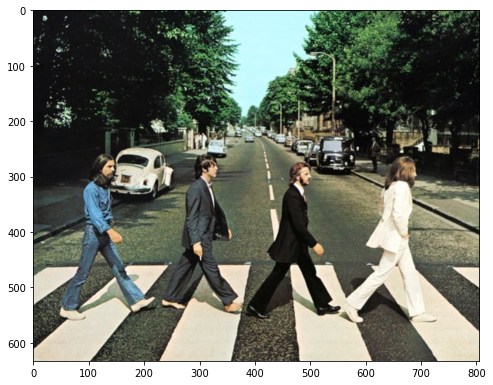

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape: ', img.shape)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)

# Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
- https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
- pretrained 모델은 http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
- pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt 에서 다운로드
- download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.

In [5]:
# resent50_coco + faster_rcnn
!mkdir ./pretrained
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

--2021-07-19 17:46:33--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   121MB/s    in 3.0s    

2021-07-19 17:46:36 (121 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2021-07-19 17:46:36--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.git

In [6]:
# 압축 풀고 
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


In [7]:
# 파일 확인
!pwd
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

/content
total 296076
4587527 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 .
4587524 drwxr-xr-x 3 root   root      4096 Jul 19 17:47 ..
4587529 -rw-r--r-- 1 345018 5000        77 Feb  1  2018 checkpoint
4587536 -rw-r--r-- 1 345018 5000 120549957 Feb  1  2018 frozen_inference_graph.pb
4587531 -rw-r--r-- 1 345018 5000 176914228 Feb  1  2018 model.ckpt.data-00000-of-00001
4587528 -rw-r--r-- 1 345018 5000     14460 Feb  1  2018 model.ckpt.index
4587532 -rw-r--r-- 1 345018 5000   5675175 Feb  1  2018 model.ckpt.meta
4587530 -rw-r--r-- 1 345018 5000      3240 Feb  1  2018 pipeline.config
4587533 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 saved_model


## dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [8]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')

## coco 데이터 세트의 클래스 id별 클래스명 확인

In [9]:
# OpenCV Yolo용 
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [10]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [11]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


### 이미지를 preprocessing 수행하여 network에 입력하고 object detection 수행 후 결과를 이미지에 시각화

In [12]:
img.shape

(633, 806, 3)

In [13]:
# 원본 이미지가 Faster RCNN 기반 network로 입력 시 resize 됨.
# scaling 된 이미지 기반으로 bounding box 위치가 예측되므로 이를 다시 원본 하기 위해 원본 이미지 shape 정보 필요
rows = img.shape[0]
cols = img.shape[1]

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하기 때문에 그림 표현을 위한 별도의 이미지 배열 생성(꼬이지 않기 위해)
draw_img = img.copy()

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 마지막 classification layer가 densce가 아니기 때문에 size를 고정할 필요는 없음.
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

(1, 1, 100, 7)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6930
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012


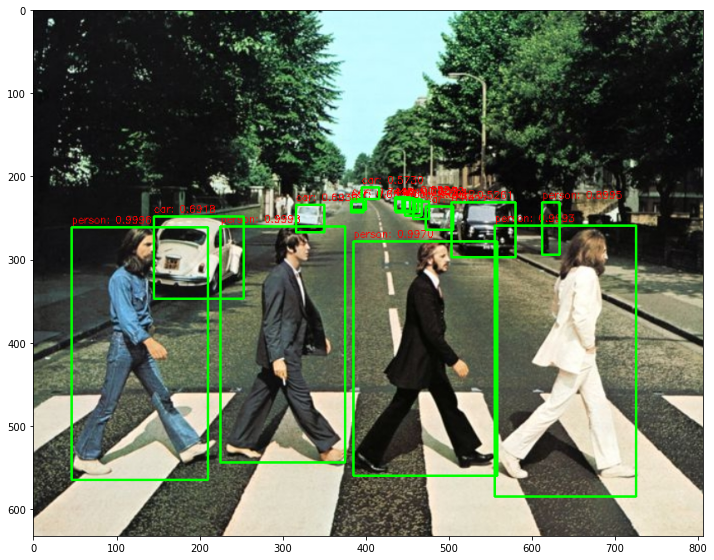

In [16]:
# Object detection 수행하여 결과를 cv_out으로 반환
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color = (0,255,0)
red_color = (0,0,255)

# detected object를 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2]) # confidence score
    class_id = int(detection[1]) # class_id
    # detected object's score가 0.5 이상만 추출
    if score > 0.5:
        # detected object는 scale된 기준으로 예측되므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows

        # labels_to_names_seq 딕셔너리로 class_id 값을 클래스 명으로 변경
        caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
        print(caption)

        # cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 "정수형"
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [17]:
# cv_out 확인 (왜 위의 함수에서 저런 로직을 가지는지)
cv_out

array([[[[0.00000000e+00, 0.00000000e+00, 9.99780715e-01,
          2.80248284e-01, 4.11070347e-01, 4.66062069e-01,
          8.59829903e-01],
         [0.00000000e+00, 0.00000000e+00, 9.99588192e-01,
          5.82912564e-02, 4.13466036e-01, 2.61212528e-01,
          8.93701494e-01],
         [0.00000000e+00, 0.00000000e+00, 9.99259293e-01,
          6.89431846e-01, 4.10281926e-01, 8.99752796e-01,
          9.24375653e-01],
         [0.00000000e+00, 0.00000000e+00, 9.96988714e-01,
          4.78255421e-01, 4.39302981e-01, 6.92748547e-01,
          8.84738147e-01],
         [0.00000000e+00, 0.00000000e+00, 8.99451733e-01,
          7.59500206e-01, 3.65392357e-01, 7.86593020e-01,
          4.65826124e-01],
         [0.00000000e+00, 0.00000000e+00, 2.80753374e-01,
          7.87774742e-01, 3.81029904e-01, 8.25374067e-01,
          4.47248816e-01],
         [0.00000000e+00, 0.00000000e+00, 1.82083517e-01,
          3.73442054e-01, 3.48522216e-01, 3.83972704e-01,
          4.01509136e-01],

## 단일 이미지의 object detection을 함수로 생성

In [22]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    rows = img_array.shape[0]
    cols = img_array.shape[1]

    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))

    start = time.time()
    cv_out = cv_net.forward()

    green_color = (0,255,0)
    red_color = (0,0,255)

    # detected objects들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])

        # detected 0bjects 의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # detected objects 는 scaled 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows

            # labels_to_names 딕셔너리로 class_id 값을 클래스명으로 변경. opecnCV 에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            print(caption)

            # cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형
            cv2.rectangle(draw_img, (int(left), int(top)),  (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    if is_print:
        print('Detection 수행 시간: ', round(time.time() - start, 2), '초')
    
    return draw_img

image shape:  (633, 806, 3)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6930
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012
Detection 수행 시간:  8.2 초


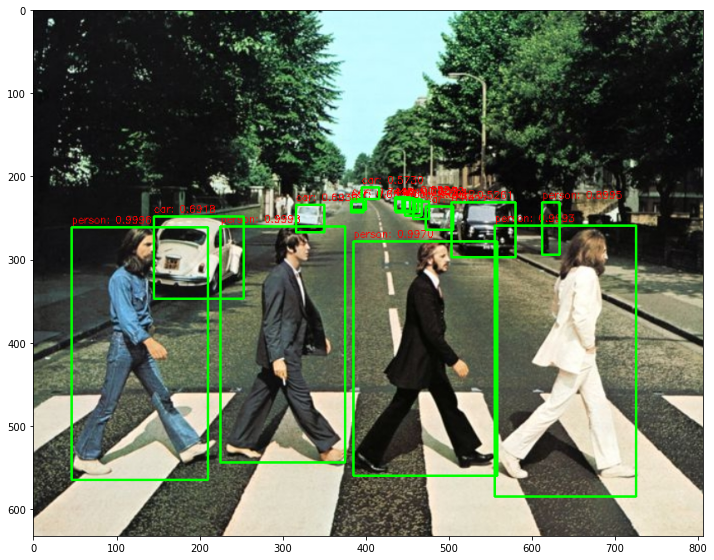

In [23]:
# image 로드
img = cv2.imread('./data/beatles01.jpg')
print('image shape: ', img.shape)

# tensorflow inference model loading
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')

# object detection 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)

In [24]:
# 다른 image 테스트
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-07-19 18:14:26--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.01s   

2021-07-19 18:14:26 (7.34 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



image shape: (476, 735, 3)
person: 0.9998
person: 0.9997
person: 0.9977
sports ball: 0.8867
baseball bat: 0.8420
baseball glove: 0.9815
Detection 수행 시간:  7.01 초


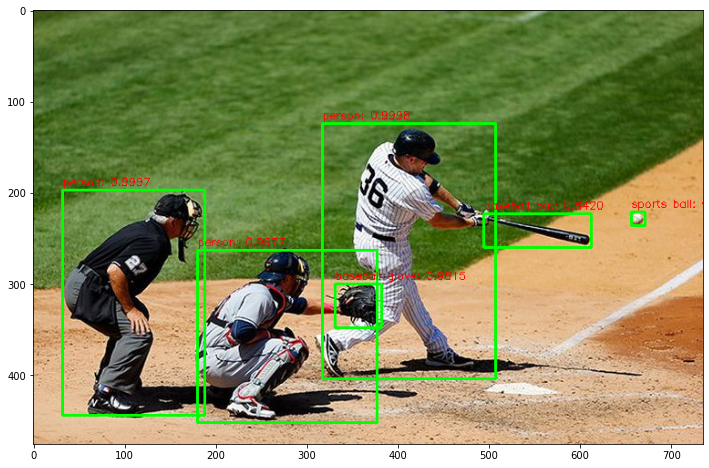

In [25]:
img = cv2.imread('./data/baseball01.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

## Video Object detection 수행

In [26]:
# 원본 영상
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2021-07-19 18:15:09--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2021-07-19 18:15:09--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2021-07-19 18:15:10--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

### VideoCapture와 VideoWriter 설정하기
- VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
- VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정.
- VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정

In [27]:
video_input_path = '/content/data/Jonh_Wick_small.mp4'

cap = cv2.VideoCapture(video_input_path)
frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 frame 갯수: ', frame_cnt)

총 frame 갯수:  58


In [31]:
video_input_path = '/content/data/Jonh_Wick_small.mp4'
video_output_path = './data/John_Wick_small_cv01.mp4'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) 
vid_fps = cap.get(cv2.CAP_PROP_FPS )

vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 frame 갯수: ', frame_cnt)

총 frame 갯수:  58


### 총 Frame 별로 iteration 하면서 Object Detection 수행. 개별 frame별로 단일 이미지 Object Detection과 유사

In [32]:
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

while True:

    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break

    rows = img_frame.shape[0]
    cols = img_frame.shape[1]
    # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_frame,  swapRB=True, crop=False))
    
    start= time.time()
    # Object Detection 수행하여 결과를 cv_out으로 반환 
    cv_out = cv_net.forward()
    frame_index = 0
    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.5 이상만 추출
        if score > 0.5:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names_0딕셔너리로 class_id값을 클래스명으로 변경.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            #print(class_id, caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(img_frame, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(img_frame, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
    print('Detection 수행 시간:', round(time.time()-start, 2),'초')
    vid_writer.write(img_frame)
# end of while loop

vid_writer.release()
cap.release()   

Detection 수행 시간: 8.05 초
Detection 수행 시간: 7.96 초
Detection 수행 시간: 7.97 초
Detection 수행 시간: 7.88 초
Detection 수행 시간: 7.87 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 7.92 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 8.21 초
Detection 수행 시간: 7.97 초
Detection 수행 시간: 8.07 초
Detection 수행 시간: 8.05 초
Detection 수행 시간: 8.05 초
Detection 수행 시간: 8.0 초
Detection 수행 시간: 7.96 초
Detection 수행 시간: 7.95 초
Detection 수행 시간: 7.92 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 7.94 초
Detection 수행 시간: 7.91 초
Detection 수행 시간: 7.89 초
Detection 수행 시간: 7.94 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 8.01 초
Detection 수행 시간: 8.02 초
Detection 수행 시간: 7.96 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 8.01 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 7.85 초
Detection 수행 시간: 7.89 초
Detection 수행 시간: 7.94 초
Detection 수행 시간: 8.0 초
Detection 수행 시간: 7.91 초
Detection 수행 시간: 7.93 초
Detection 수행 시간: 8.0 초
Detection 수행 시간: 8.0 초
Detection 수행 시간: 7.99 초
Detection 수행 시간: 7.9

### video detection 전용 함수

In [33]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    cap = cv2.VideoCapture(input_path)
    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 frame 갯수: ', frame_cnt)

    green_color = (0, 255, 0)
    red_color = (0, 0, 255)

    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 Frame이 없습니다.')
            break

        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)

        vid_writer.write(img_frame)

    
    vid_writer.release()
    cap.release()

In [34]:
do_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.2, False)

총 frame 갯수:  58
person: 0.9495
person: 0.2871
bicycle: 0.3498
car: 0.9882
car: 0.9622
car: 0.9266
car: 0.8772
car: 0.3988
car: 0.3763
car: 0.2583
car: 0.2150
motorcycle: 0.6607
book: 0.2069
person: 0.9581
person: 0.4459
person: 0.2940
bicycle: 0.4216
car: 0.9881
car: 0.9643
car: 0.9318
car: 0.8992
car: 0.4418
car: 0.4189
car: 0.2545
car: 0.2318
motorcycle: 0.5682
person: 0.7814
person: 0.5169
person: 0.3087
car: 0.9903
car: 0.9833
car: 0.9115
car: 0.8625
car: 0.4893
car: 0.4251
motorcycle: 0.9532
airplane: 0.2046
person: 0.7585
person: 0.7484
person: 0.7375
person: 0.7200
person: 0.3580
person: 0.2285
person: 0.2171
car: 0.9919
car: 0.9909
car: 0.9870
car: 0.7361
car: 0.6120
motorcycle: 0.8655
umbrella: 0.4362
person: 0.5313
person: 0.4869
person: 0.4709
car: 0.9933
car: 0.9817
car: 0.9530
car: 0.7823
car: 0.2064
motorcycle: 0.9781
truck: 0.4717
person: 0.8299
person: 0.4792
person: 0.2719
car: 0.9799
car: 0.9678
car: 0.9496
car: 0.6521
car: 0.4466
car: 0.4120
car: 0.2396
car: 0.2354
c